In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.to_numpy().shape

(42000, 785)

In [5]:
test.to_numpy().shape

(28000, 784)

In [6]:
train_image = train.to_numpy()[0:,1:].reshape(42000,28,28,1)
test_image = test.to_numpy().reshape(28000,28,28,1)

In [7]:
train_image = train_image.astype(float) / 255.0
test_image = test_image.astype(float) / 255.0

In [8]:
def add_noise(image):
    img = np.copy(image)
    row , col, _ = img.shape
     
    number_of_pixels = random.randint(210, 240)
    for i in range(number_of_pixels):
       
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)

        img[y_coord,x_coord,:] = random.random()
    
    return img

In [9]:
def train_noise(train_image_y):
    print('Adding Noise')
    train_image = np.copy(train_image_y)
    for i,img in tqdm(enumerate(train_image), total = len(train_image)):
        train_image[i] = add_noise(img)
    return train_image

(28, 28, 1)


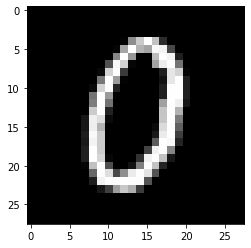

In [10]:
img = train_image[5]
print(img.shape)
plt.imshow(img.squeeze(), cmap = 'gray')

(28, 28, 1)


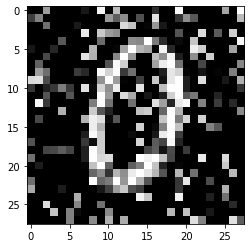

In [11]:
img = add_noise(train_image[5])
print(img.shape)
plt.imshow(img.squeeze(), cmap= 'gray')

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import InputLayer, Conv2D, LeakyReLU, Conv2DTranspose
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [13]:
class AutoEncoder(keras.Model):
    def __init__(self,input_shape):
        super(AutoEncoder,self).__init__()
        #encoder
        self.encoder = keras.Sequential([
            InputLayer(input_shape=input_shape),
            Conv2D(64,kernel_size=3,strides=2,padding='same'),
            LeakyReLU(0.001),
            Conv2D(64,kernel_size=3,strides=2,padding='same'),
            LeakyReLU(0.001)
        ])

        #decoder
        self.decoder = keras.Sequential([
            Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
            LeakyReLU(0.001),
            Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
            LeakyReLU(0.001),
            Conv2D(input_shape[2],kernel_size=3,padding='same'),
            LeakyReLU(0.001)
        ])

    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
ae = AutoEncoder((28,28,1))

In [15]:
opt = Adam(0.0001)
loss = MeanSquaredError()

In [16]:
ae.compile(optimizer = opt,loss = loss)

In [17]:
my_callbacks = [keras.callbacks.EarlyStopping(patience=5)]
history = ae.fit(train_noise(train_image),train_image,batch_size=128,epochs=100,verbose=1,validation_split=0.25, callbacks = my_callbacks)

  0%|          | 146/42000 [00:00<00:28, 1452.82it/s]

Adding Noise


100%|██████████| 42000/42000 [00:30<00:00, 1373.73it/s]


Epoch 1/100
247/247 [==============================] - 10s 13ms/step - loss: 0.0668 - val_loss: 0.0132
Epoch 2/100
247/247 [==============================] - 2s 10ms/step - loss: 0.0119 - val_loss: 0.0098
Epoch 3/100
247/247 [==============================] - 3s 11ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 4/100
247/247 [==============================] - 3s 10ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 5/100
247/247 [==============================] - 2s 10ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 6/100
247/247 [==============================] - 2s 10ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 7/100
247/247 [==============================] - 3s 10ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 8/100
247/247 [==============================] - 3s 10ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 9/100
247/247 [==============================] - 3s 10ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 10/100
247/247 [==============================] - 2s 10ms/step - loss: 0.00

In [18]:
ae.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7, 7, 64)          37568     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         74433     
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________


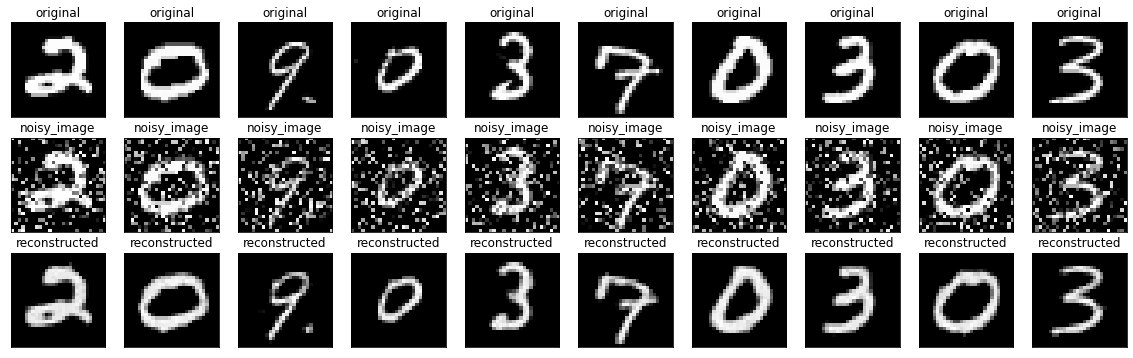

In [19]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    noisy_image = np.ndarray(test_image.shape)
    noisy_image[i] = add_noise(test_image[i])
    encoded = ae.encoder(tf.expand_dims(noisy_image[i],axis=0))
    cleaned = ae.decoder(encoded)
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(test_image[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("noisy_image")
    plt.imshow(tf.squeeze(noisy_image[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(cleaned))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

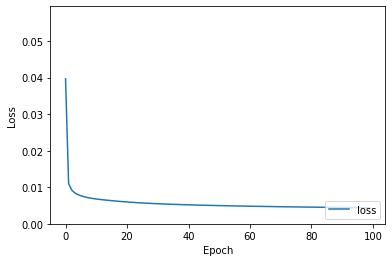

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, np.max(history.history['loss'])*(1+0.5)])
plt.legend(loc='lower right')